In [1]:
#import warnings
#warnings.filterwarnings('ignore')

import datacube

import matplotlib.pyplot as plt
import matplotlib.cm as color_maps  
from matplotlib.pyplot import figure, cm

import json
import time
import sys
import os

import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
from rasterio.plot import show

import rioxarray as rio

import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import ogr, gdal

from datetime import datetime
#from time import time

import skimage
from skimage import exposure
from skimage import morphology
from skimage.morphology import disk
from skimage.morphology import rectangle
from skimage.filters import rank

import glob
import fiona
import subprocess

import utils.data_cube_utilities.dc_utilities as utils
from utils.data_cube_utilities.data_access_api import DataAccessApi
from utils.data_cube_utilities.dc_utilities import write_geotiff_from_xr, write_png_from_xr
from utils.data_cube_utilities.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_mosaic
from utils.data_cube_utilities.dc_sar_utils import dn_to_db 

In [2]:
def rasterization(InputVector,OutputImage,RefImage):
    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels
    ##########################################################
    # Get projection info from reference image
    Image = gdal.Open(RefImage, gdal.GA_ReadOnly)
    print(Image)

    # Open Shapefile
    Shapefile = ogr.Open(InputVector)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterising
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+OutputImage+" 2 4 8 16 32 64", shell=True)


    print("Done.")

    print('finist_rasterise_vector')
    
def rgb(dataset, bands = ['nir', 'red', 'green'], paint_on_mask = []):
    
    fig=plt.figure()
    fig.set_size_inches(9, 9)
    
    rgb = np.stack([dataset[bands[0]], dataset[bands[1]], dataset[bands[2]]], axis = -1)
    rgb = rgb.astype(np.float32)

    p2, p98 = np.percentile(rgb, (2, 98))
    rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98)) * 255.0

    rgb = rgb.astype(int) 

    for mask, color in paint_on_mask:        
        rgb[mask] = np.array([256,256,256]) - np.array(color).astype(np.int16)
    plt.imshow(rgb)
        
def generate_cloud_mask(dataset, include_shadows = False):
    #Create boolean Masks for clear and water pixels
      
    clear_pixels = dataset.pixel_qa.values == (2 ) 
    water_pixels = dataset.pixel_qa.values == (4 )
    shadow_pixels= dataset.pixel_qa.values == (3 )
           
    #a_clean_mask = np.logical_or(clear_pixels, water_pixels)
    a_clean_mask = np.logical_or(1, 1)
    if include_shadows:
        a_clean_mask = np.logical_or(a_clean_mask, shadow_pixels)
        
    return np.invert(a_clean_mask)

def mrf_mosaic(dataset):
    # The mask here is based on pixel_qa products. It comes bundled in with most Landsat Products.
    cloud_free_boolean_mask = np.invert(generate_cloud_mask(dataset))
    #cloud_free_boolean_mask = generate_cloud_mask(dataset)
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

## 1. Initialization

In [18]:
sugarcane_shp = './shp/clipped_sugarcane.shp'
rice_shp = './shp/clipped_rice.shp'

#longitude_extents = (99.4011935857512015, 99.8903905394106602)
#latitude_extents = (16.2054799251247204,16.5655679805828697)

#midpoint = ((99.4011935857512015+99.8903905394106602)/2,(16.2054799251247204+16.5655679805828697)/2)

longitude_extents = (99.6175520999999975, 99.7704346999999956)
latitude_extents = (16.3128327000000013, 16.4346943000000003)

platform = "SENTINEL_2_Thailand"
product = "s2_level2a_Thailand"
                      
bands = ['coastal', 
         'blue', 'green', 'red', 
         #'veg5', 'veg6', 'veg7', 
         'nir', 'narrow_nir', 
         #'water_vapour', 'swir1', 'swir2', 
         'AOT', 'pixel_qa']
         #'SCL', 'WVP', 'AOT', 'pixel_qa']

dc = datacube.Datacube(app = 'my_app', config = '/home/ubuntu/.datacubeThailandS2.conf')

time_extents = ('2019-05-01', '2021-05-31')
#time_extents = ('2020-01-01', '2021-05-31')

n_sample = 10000
safety_factor = 1.5
result_file = ("x_train", "y_train")

## 2. Get sentinel2 data from ODC as the same size and resolution of input raster

In [4]:
start_time = time.time()
print("Mem status before loading dataset")
!cat /proc/meminfo | grep Mem

s2_dataset = dc.load(latitude = latitude_extents,
                     longitude = longitude_extents,
                     #latitude = (latitude_extents[0], midpoint[0]),
                     #longitude = (longitude_extents[0], midpoint[1]),
                     platform = platform,
                     time = time_extents,
                     product = product,
                     measurements = bands)

print("loading time:", time.time() - start_time,"Sec.")

print("Mem status after dataset loaded")
!cat /proc/meminfo | grep Mem


Mem status before loading dataset
MemTotal:       132028380 kB
MemFree:        93845768 kB
MemAvailable:   107209592 kB
loading time: 60.894705057144165 Sec.
Mem status after dataset loaded
MemTotal:       132028380 kB
MemFree:        85747636 kB
MemAvailable:   99111384 kB


In [5]:
#s2_dataset.to_netcdf("odc_on_disk.nc")

s2_dataset

<xarray.Dataset>
Dimensions:     (latitude: 1317, longitude: 1652, time: 142)
Coordinates:
  * time        (time) datetime64[ns] 2019-05-05T04:03:48.860000 ... 2021-03-15T04:03:40.170000
  * latitude    (latitude) float64 16.43 16.43 16.43 16.43 ... 16.31 16.31 16.31
  * longitude   (longitude) float64 99.62 99.62 99.62 ... 99.77 99.77 99.77
Data variables:
    coastal     (time, latitude, longitude) int16 730 730 730 ... 732 732 695
    blue        (time, latitude, longitude) int16 821 890 917 ... 949 835 806
    green       (time, latitude, longitude) int16 1084 1172 1302 ... 1042 979
    red         (time, latitude, longitude) int16 1184 1268 1418 ... 1170 933
    nir         (time, latitude, longitude) int16 1230 1280 1376 ... 2170 2466
    narrow_nir  (time, latitude, longitude) int16 1252 1252 1395 ... 2600 2810
    AOT         (time, latitude, longitude) int16 456 456 456 ... 713 713 713
    pixel_qa    (time, latitude, longitude) int16 10 10 10 10 8 8 ... 5 5 5 5 5
Attributes:
    crs:      EPSG:4326

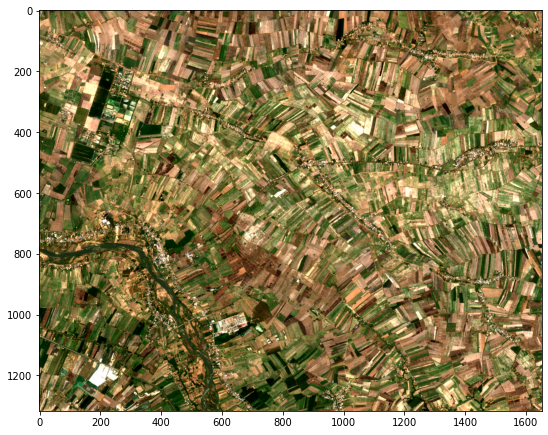

In [6]:
s2_mosaic=mrf_mosaic(s2_dataset)
s2_mosaic

#draw image
rgb(s2_mosaic, bands=['red','green','blue'])

#save mosaic to GeoTIFF and will be use as RefImage 
measurements = ['red', 'green', 'blue']
RefImage = './refImage.tif'
write_geotiff_from_xr(RefImage, s2_mosaic, measurements)

In [7]:
#Image area in sq.km.
1652*1317*(100)/(1000*1000)

217.5684

## 1. read shape file

In [8]:
def records(file):  
    # generator 
    reader = ogr.Open(file)
    layer = reader.GetLayer(0)
    result = []
    for i in range(layer.GetFeatureCount()):
        feature = layer.GetFeature(i)
        polygon = json.loads(feature.ExportToJson())
        geojson = json.dumps(polygon['geometry'])
        tmp_polygon = ogr.CreateGeometryFromJson(geojson)
        result.append(tmp_polygon)
    return result
        
def in_polygon(lat, lon, shp_records):
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(lon, lat)

    for i, polygon in enumerate(shp_records):
        if point.Within(polygon):
            return True
        
    return False

In [9]:
sugarcane_area = records(sugarcane_shp)
rice_area = records(rice_shp)

In [10]:
#try in-polygon test
sugar_point = (16.4006, 99.7045)
rice_point = (16.3647, 99.6797)

print("is sugar_point in sugar_area", in_polygon(sugar_point[0], sugar_point[1], sugarcane_area))
print("is sugar_point in rice_area", in_polygon(sugar_point[0], sugar_point[1], rice_area))
print("is rice_point in sugar_area", in_polygon(rice_point[0], rice_point[1], sugarcane_area))
print("is rice_point in rice_area", in_polygon(rice_point[0], rice_point[1], rice_area))

is sugar_point in sugar_area True
is sugar_point in rice_area False
is rice_point in sugar_area False
is rice_point in rice_area True


## 3. Sampling locations from (1.)

In [19]:
import random

#list of (lat,lon)
sugarcane_points = []
rice_points = []
labels = []

#n_sample = 5
count = 0

print("start_sampling n=",n_sample*safety_factor)

while len(sugarcane_points) < n_sample*safety_factor or len(rice_points) < n_sample*safety_factor :
        
    lat = random.choice(s2_dataset.latitude.data)
    lon = random.choice(s2_dataset.longitude.data)
    
    
    if in_polygon(lat, lon, sugarcane_area) and len(sugarcane_points) < n_sample*safety_factor:
        #print(lat, lon)
        #print("sugar")
        sugarcane_points.append((lat,lon))
        labels.append(1)
    elif in_polygon(lat, lon, rice_area) and len(rice_points) < n_sample*safety_factor:
        #print(lat, lon)
        #print("rice")
        rice_points.append((lat,lon))
        labels.append(0)
    
    count += 1
    if count<10 or count%300 == 0:
        print("iteration:", count, "sugarcane_points:", len(sugarcane_points), "rice_points:", len(rice_points))
        

start_sampling n= 15000.0
iteration: 1 sugarcane_points: 0 rice_points: 1
iteration: 2 sugarcane_points: 0 rice_points: 2
iteration: 3 sugarcane_points: 0 rice_points: 3
iteration: 4 sugarcane_points: 0 rice_points: 3
iteration: 5 sugarcane_points: 0 rice_points: 4
iteration: 6 sugarcane_points: 0 rice_points: 5
iteration: 7 sugarcane_points: 1 rice_points: 5
iteration: 8 sugarcane_points: 2 rice_points: 5
iteration: 9 sugarcane_points: 2 rice_points: 6
iteration: 300 sugarcane_points: 128 rice_points: 115
iteration: 600 sugarcane_points: 256 rice_points: 228
iteration: 900 sugarcane_points: 409 rice_points: 340
iteration: 1200 sugarcane_points: 544 rice_points: 447
iteration: 1500 sugarcane_points: 679 rice_points: 569
iteration: 1800 sugarcane_points: 798 rice_points: 705
iteration: 2100 sugarcane_points: 933 rice_points: 817
iteration: 2400 sugarcane_points: 1058 rice_points: 937
iteration: 2700 sugarcane_points: 1197 rice_points: 1038
iteration: 3000 sugarcane_points: 1344 rice_poi

In [20]:
len(labels)

30000

## 4. get NDVI value from (2) using locations from (3) 

 $$ {NDVI} = \frac{(X_{NIR}-X_{Red})}{(X_{NIR}+X_{Red})}$$


In [13]:
allpoints = []
allpoints.extend(sugarcane_points)
allpoints.extend(rice_points)

(lat, lon) = allpoints[0]



In [14]:
(lat, lon) 

(16.3558917, 99.7499701)

In [15]:
week_year_array = None
ndvi_array = None

for (lat,lon) in allpoints:
    pixel_mosaic = s2_dataset.sel(latitude=lat, longitude=lon)
    pixel_mosaic
    tmp_ndvi = ((pixel_mosaic['nir'].values - pixel_mosaic['red'].values).astype(np.double)/
                      (pixel_mosaic['nir'].values + pixel_mosaic['red'].values + .0001).astype(np.double))

    tmp_df = pd.DataFrame({'timestamp': pixel_mosaic['time'].values, 'ndvi': tmp_ndvi})
    tmp_df['week_year'] = tmp_df['timestamp'].dt.strftime("%Y-%U")
    tmp_df = tmp_df[['week_year', 'ndvi']].groupby('week_year').max()
    tmp_df = tmp_df.reset_index()
    
    if week_year_array is None:
        week_year_array = tmp_df['week_year'].to_numpy()
    
    if ndvi_array is None:
        ndvi_array = np.array([tmp_df['ndvi'].to_numpy()])
    else:
        ndvi_array = np.append(ndvi_array,
                               np.array([tmp_df['ndvi'].to_numpy()]), 
                               axis=0)


In [16]:
week_year_array

array(['2019-18', '2019-19', '2019-20', '2019-21', '2019-22', '2019-23',
       '2019-24', '2019-25', '2019-26', '2019-27', '2019-28', '2019-29',
       '2019-30', '2019-31', '2019-32', '2019-33', '2019-34', '2019-35',
       '2019-36', '2019-37', '2019-38', '2019-39', '2019-40', '2019-41',
       '2019-42', '2019-43', '2019-44', '2019-45', '2019-46', '2019-47',
       '2019-48', '2019-49', '2019-50', '2019-51', '2019-52', '2020-01',
       '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
       '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2020-13',
       '2020-14', '2020-15', '2020-16', '2020-17', '2020-18', '2020-19',
       '2020-20', '2020-21', '2020-22', '2020-23', '2020-24', '2020-25',
       '2020-26', '2020-27', '2020-28', '2020-29', '2020-30', '2020-31',
       '2020-32', '2020-33', '2020-34', '2020-35', '2020-36', '2020-37',
       '2020-38', '2020-39', '2020-40', '2020-41', '2020-42', '2020-43',
       '2020-44', '2020-45', '2020-46', '2020-47', 

In [17]:
ndvi_array.shape


(20000, 98)

## 5. Smoothing and imputation

## 6. Create numpy array